In [54]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import random
import seaborn as sns
#import matplotlib as mpl
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers

In [55]:
# Random seed for reproducibility
seed = 1

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [56]:
# Utility function to create folders and callbacks for training
from datetime import datetime

exp_dir = ''

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%Y-%m-%d_%H:%M')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tfk.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'),
                                                save_weights_only=False,
                                                save_best_only=False)
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)
  callbacks.append(tb_callback)

In [57]:
#!unzip ANN_HW1.zip
#import zipfile
#with zipfile.ZipFile("dataset.zip", 'r') as z:
#    z.extractall()

In [58]:
# Set the path to the dataset 

dataset_dir = '../input/homework1-split/'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

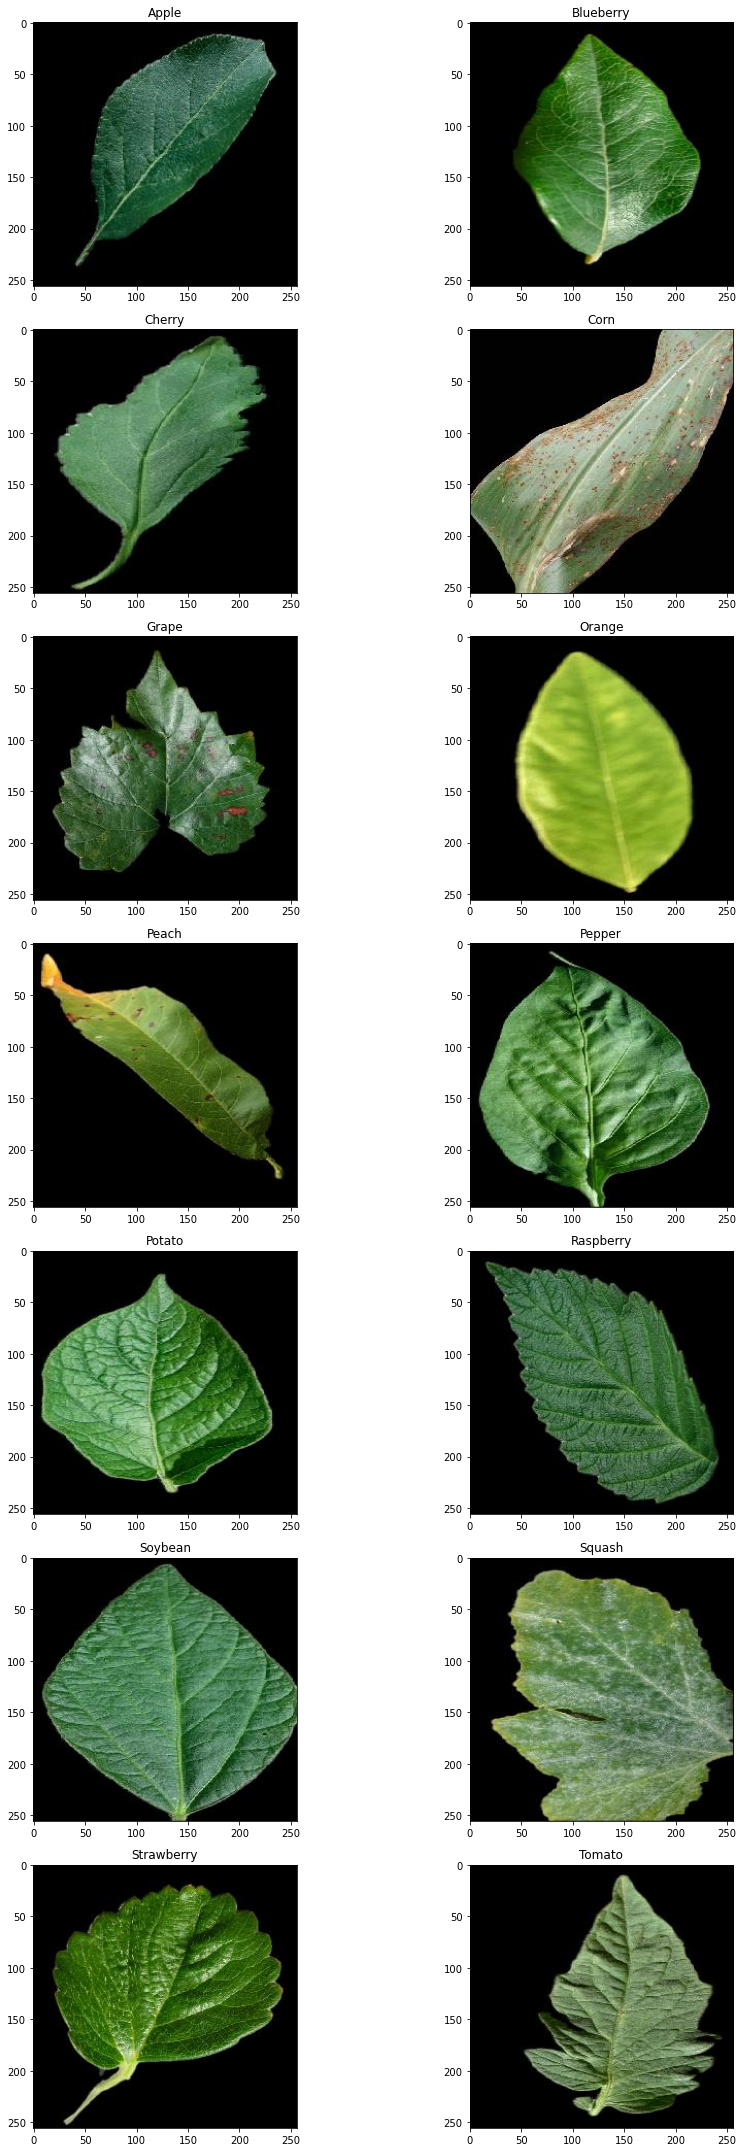

In [59]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
    if i < len(labels):
        class_imgs = next(os.walk('{}/{}/'.format(training_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/{}/{}'.format(training_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [60]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_gen = ImageDataGenerator(rotation_range=30,
                              height_shift_range=50,
                              width_shift_range=50,
                              zoom_range=0.3,
                              horizontal_flip=True,
                              vertical_flip=True, 
                              fill_mode='reflect',
                              rescale=1/255)   
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method

train_dataset = train_gen.flow_from_directory(directory=training_dir,
                                                target_size=(256,256),
                                                color_mode='rgb',
                                                classes=None,
                                                batch_size=8,
                                                shuffle=True,
                                                class_mode='categorical',
                                                seed=seed)


valid_gen = ImageDataGenerator(rescale=1/255.)   

validation_dataset = valid_gen.flow_from_directory(directory=validation_dir,
                                                target_size=(256,256),
                                                color_mode='rgb',
                                                classes=None,
                                                batch_size=8,
                                                shuffle=True,
                                                class_mode='categorical',
                                                seed=seed)

Found 14176 images belonging to 14 classes.
Found 3552 images belonging to 14 classes.


In [61]:
input_shape = (256, 256, 3)
epochs = 15
learning_rate = 0.001
model_name = '3layers_earlystop_aug'

In [62]:
def build_model(input_shape):
#create model

    model = tfk.Sequential()
    model.add(tfkl.Conv2D(16, kernel_size=(5, 5),activation='relu',padding='same', kernel_initializer=tfk.initializers.GlorotUniform(seed), input_shape=input_shape))
    model.add(tfkl.MaxPooling2D((2, 2),strides=(2,2)))

    model.add(tfkl.Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same', kernel_initializer=tfk.initializers.GlorotUniform(seed)))
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    
    model.add(tfkl.Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same', kernel_initializer=tfk.initializers.GlorotUniform(seed)))
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    
    model.add(tfkl.Flatten())

    model.add(tfkl.Dense(128, activation='relu', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer=tfk.regularizers.l2(1e-3)))
    model.add(tfkl.Dropout(0.5))
    model.add(tfkl.Dense(14, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    
    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics='accuracy')

    # Return the model
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 64)      

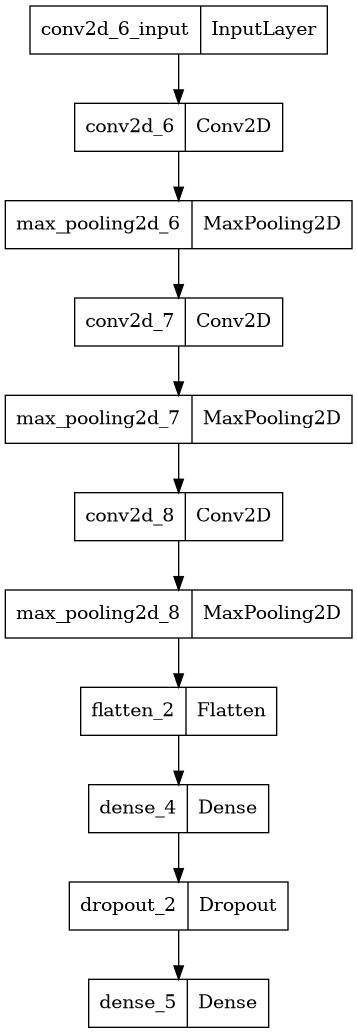

In [63]:
model = build_model(input_shape)
model.summary()
tfk.utils.plot_model(model)

In [64]:
callbacks = create_folders_and_callbacks(model_name=model_name)

# Train the model
history = model.fit(
    x = train_dataset,
    epochs = epochs,
    batch_size = 32,
    validation_data = validation_dataset,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

Epoch 1/15
   7/1772 [..............................] - ETA: 55:22 - loss: 3.0009 - accuracy: 0.2857  

KeyboardInterrupt: 

In [ ]:
# Save the model
model.save(os.path.join(exp_dir, model_name))

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()